In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from peewee import *
from datetime import date, datetime
import matplotlib.dates as mdates
import re

In [2]:
db = MySQLDatabase('airfares', user='root', password='toor', host='localhost', autocommit=True)

In [3]:
class Flight(Model):
    flightKey = CharField(max_length=255, unique=True, index=True)
    flightNumber = CharField(max_length=50)
    departureDate = DateField()
    arrivalDate = DateField()
    departureTime = TimeField()
    arrivalTime = TimeField()
    journeyDuration = TimeField()
    totalNumberOfStops = IntegerField()
    carrierCode = CharField(max_length=50)
    depAirportCode = CharField(max_length=50)
    arrAirportCode = CharField(max_length=50)

    class Meta:
        database = db

class Price(Model):
    priceID = AutoField()
    flightKey = ForeignKeyField(Flight, to_field='flightKey', on_delete='CASCADE', on_update='CASCADE')
    scrapeDate = DateField()
    availableSeats = IntegerField()
    adultPrice = FloatField()

    class Meta:
        database = db

class Airport(Model):
    airportCode = CharField(max_length=50, unique=True, index=True)
    airportName = CharField(max_length=255)
    city = CharField(max_length=255)
    country = CharField(max_length=255)

    class Meta:
        database = db

class Airline(Model):
    carrierCode = CharField(max_length=50, unique=True, index=True)
    carrierName = CharField(max_length=255)

    class Meta:
        database = db

In [4]:
db.connect()
query1 = Flight.select().dicts()
query2 = Price.select().dicts()
query3 = Airport.select().dicts()
query4 = Airline.select().dicts()

flight_data = list(query1)
price_data = list(query2)
airport_data = list(query3)
airline_data = list(query4)

df_flight = pd.DataFrame(flight_data)
df_price = pd.DataFrame(price_data)
df_airport = pd.DataFrame(airport_data)
df_airline = pd.DataFrame(airline_data)
db.close()

True

In [17]:
df_flight

,id,flightKey,flightNumber,departureDate,arrivalDate,departureTime,arrivalTime,journeyDuration,totalNumberOfStops,carrierCode,depAirportCode,arrAirportCode
0,1,TB_OST_ALC_2023-04-09_TB1183,TB1183,2023-04-09,2023-04-09,06:00:00,08:50:00,02:50:00,0,TB,OST,ALC
1,2,TB_BRU_ALC_2023-04-09_TB1111,TB1111,2023-04-09,2023-04-09,06:10:00,08:55:00,02:45:00,0,TB,BRU,ALC
2,3,TB_ANR_ALC_2023-04-09_TB1101,TB1101,2023-04-09,2023-04-09,08:30:00,11:15:00,02:45:00,0,TB,ANR,ALC
3,4,TB_ANR_ALC_2023-04-09_TB1103,TB1103,2023-04-09,2023-04-09,14:05:00,16:45:00,02:40:00,0,TB,ANR,ALC
4,5,TB_ANR_ALC_2023-04-09_TB1105,TB1105,2023-04-09,2023-04-09,15:20:00,18:00:00,02:40:00,0,TB,ANR,ALC
...,...,...,...,...,...,...,...,...,...,...,...,...
5493,5494,TB_BRU_FAO_2023-06-22_TB1315,TB1315,2023-06-22,2023-06-22,14:25:00,18:00:00,04:35:00,1,TB,BRU,FAO
5494,5495,TB_BRU_AGP_2023-06-22_TB1011,TB1011,2023-06-22,2023-06-22,06:00:00,09:05:00,03:05:00,0,TB,BRU,AGP
5495,5496,TB_BRU_FAO_2023-06-29_TB1315,TB1315,2023-06-29,2023-06-29,14:25:00,18:00:00,04:35:00,1,TB,BRU,FAO
5496,5497,TB_BRU_AGP_2023-06-29_TB1011,TB1011,2023-06-29,2023-06-29,06:00:00,09:05:00,03:05:00,0,TB,BRU,AGP


In [5]:
df_price

,priceID,flightKey,scrapeDate,availableSeats,adultPrice
0,1,TB_OST_ALC_2023-04-09_TB1183,2023-04-07,5,149.99
1,2,TB_BRU_ALC_2023-04-09_TB1111,2023-04-07,-1,129.99
2,3,TB_ANR_ALC_2023-04-09_TB1101,2023-04-07,9,99.99
3,4,TB_ANR_ALC_2023-04-09_TB1103,2023-04-07,9,129.99
4,5,TB_ANR_ALC_2023-04-09_TB1105,2023-04-07,-1,99.99
...,...,...,...,...,...
66504,66505,HV_BRU_TFS_2023-09-16_HV9061,2023-04-19,10,154.00
66505,66506,HV_BRU_TFS_2023-09-20_HV9061,2023-04-19,-1,154.00
66506,66507,HV_BRU_TFS_2023-09-23_HV9061,2023-04-19,8,170.00
66507,66508,HV_BRU_TFS_2023-09-27_HV9061,2023-04-19,4,185.00


### (1) Welke vliegtuigmaatschappij is gemiddeld de goedkoopste / de duurste?

##### Ryanair

In [6]:
ryanair_mean_price = df_price[df_price['flightKey'].isin(df_flight[df_flight['carrierCode'] == 'FR']['flightKey'])]['adultPrice'].mean()

##### Tui

In [7]:
tui_mean_price = df_price[df_price['flightKey'].isin(df_flight[df_flight['carrierCode'] == 'TB']['flightKey'])]['adultPrice'].median()

##### Transavia

In [8]:
transavia_mean_price = df_price[df_price['flightKey'].isin(df_flight[df_flight['carrierCode'] == 'HV']['flightKey'])]['adultPrice'].median()

<BarContainer object of 3 artists>

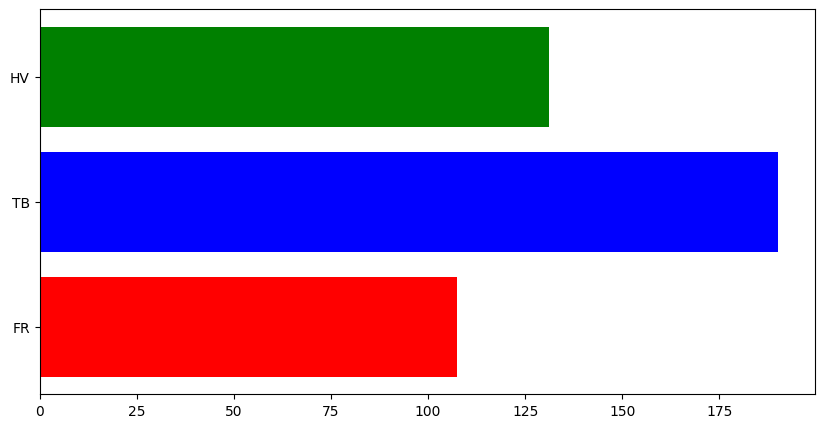

In [9]:
plt.figure(figsize=(10, 5))

carrier_codes = ['FR', 'TB', 'HV']
carrier_names = ['Ryanair', 'TUI', 'Transavia']

carrier_mean_prices = [ryanair_mean_price, tui_mean_price, transavia_mean_price]

colors = ['red', 'blue', 'green']

plt.barh(carrier_codes, carrier_mean_prices, color=colors)

### (8) Zijn de prijzen gerelateerd aan vakantieperiodes hier of ter plaatse?

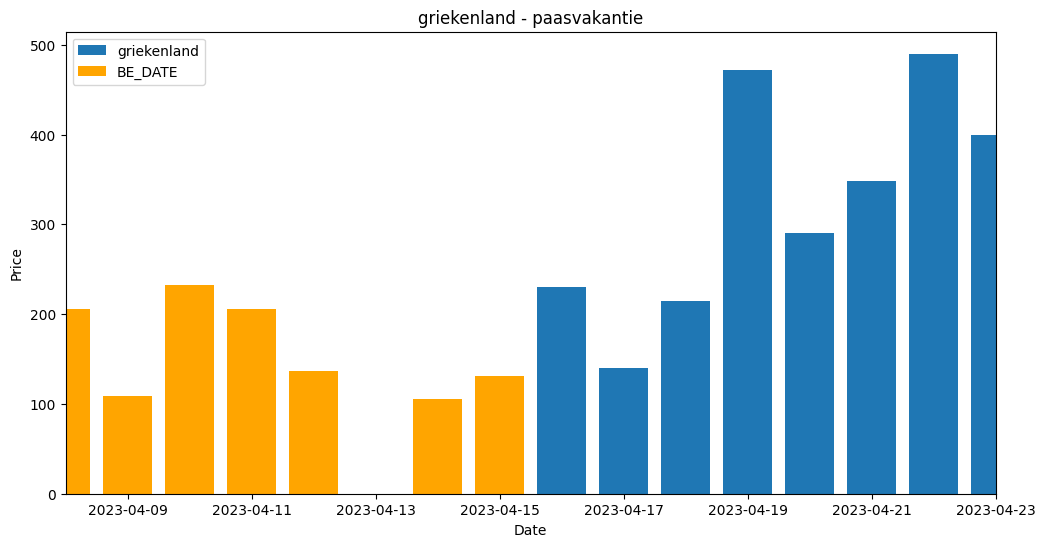

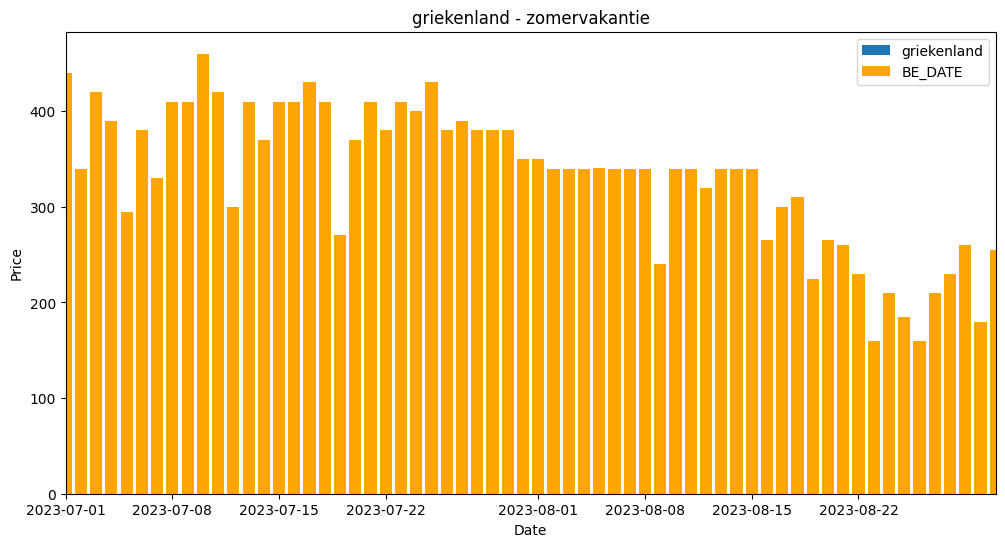

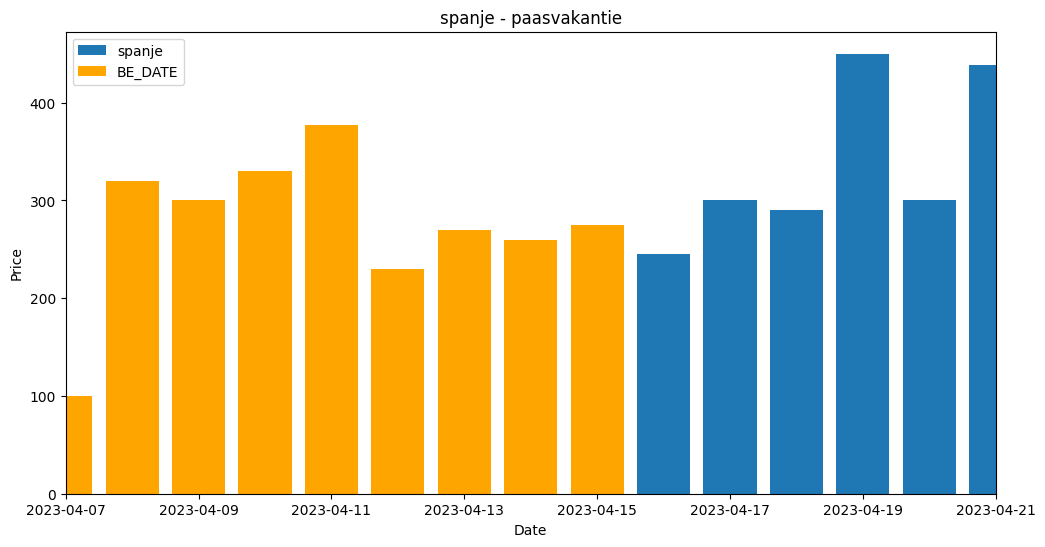

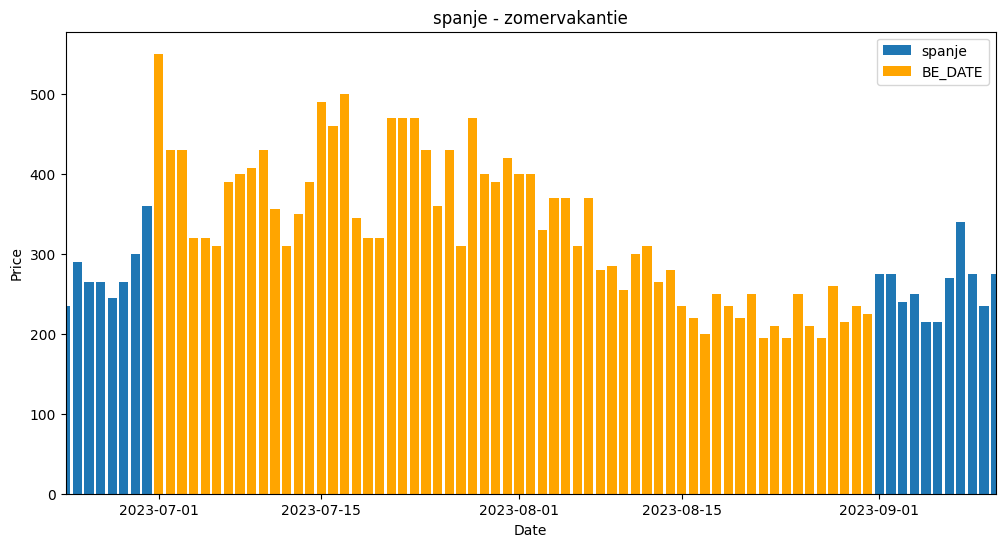

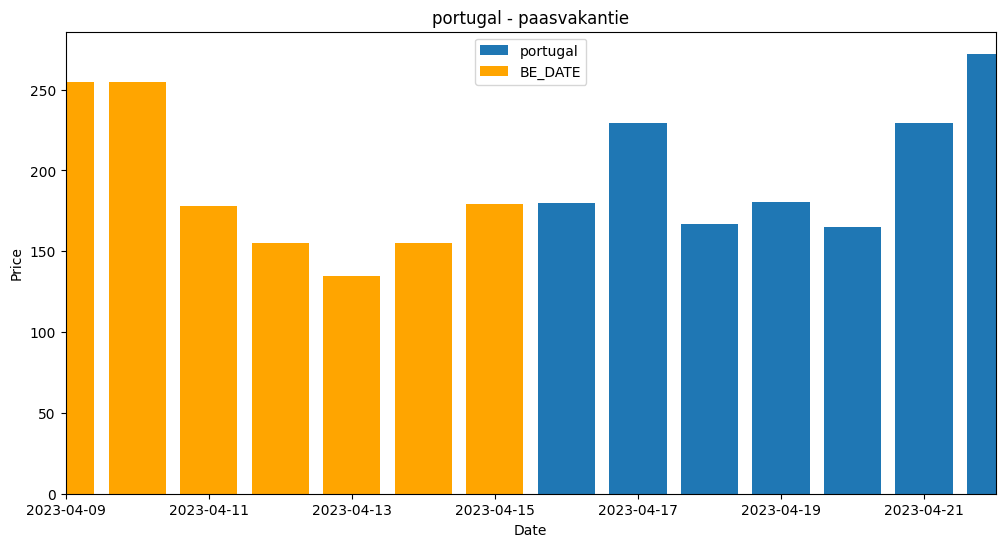

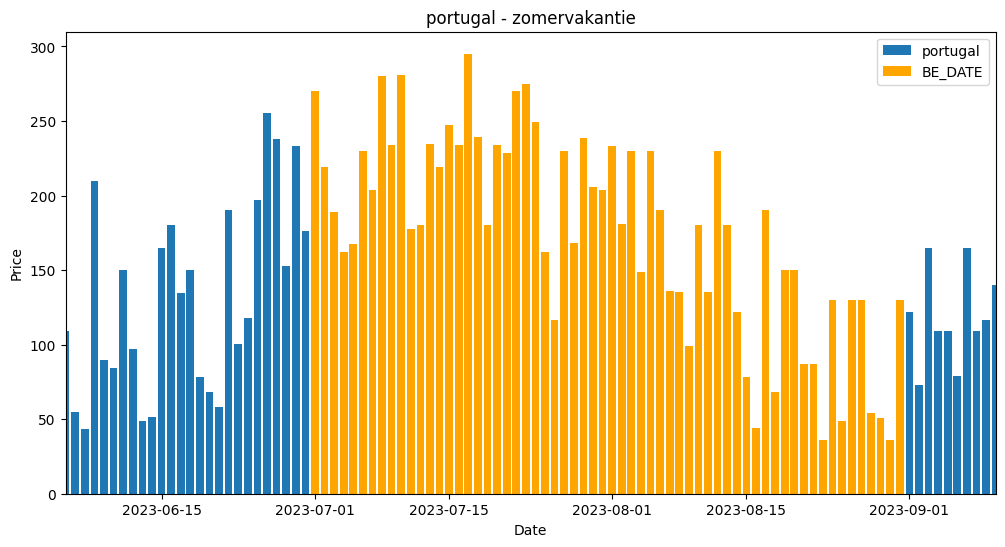

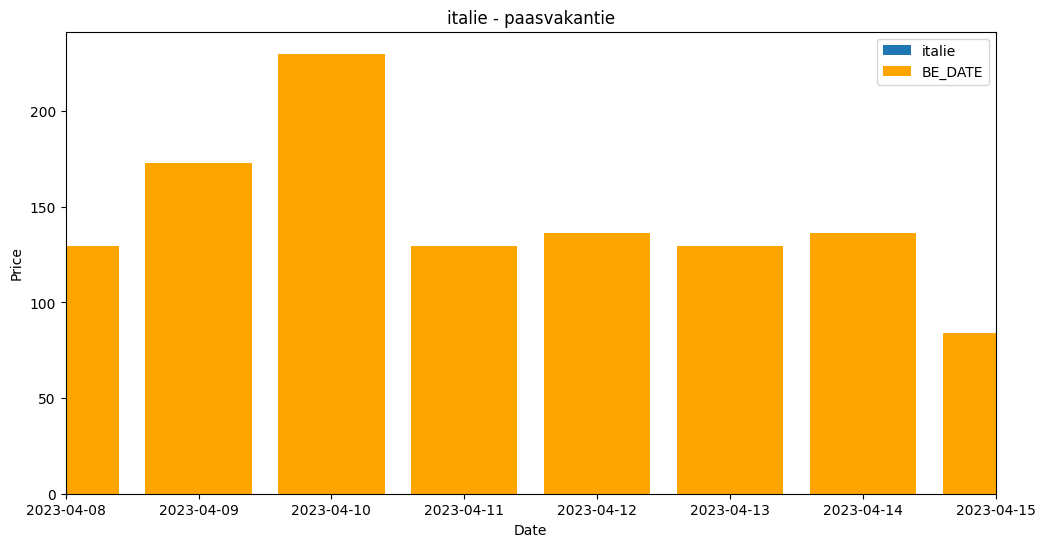

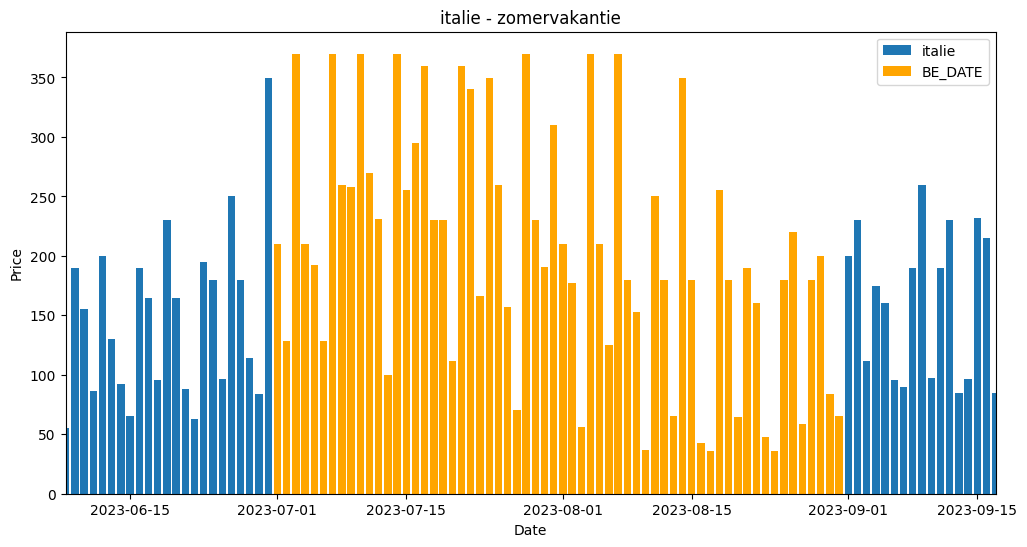

In [42]:
vakantie_periodes = {
    'griekenland': {
        'paasvakantie': ['2023-04-16', '2023-04-23'],
        'zomervakantie': ['2023-07-01', '2023-08-31'],
    }, 

    'spanje': {
        'paasvakantie': ['2023-04-04', '2023-04-21'],
        'zomervakantie': ['2023-06-23', '2023-09-11'],
    },

    'portugal': {
        'paasvakantie': ['2023-04-08', '2023-04-22'],
        'zomervakantie': ['2023-06-05', '2023-09-10'],
    },

    'italie': {
        'paasvakantie': ['2023-04-09', '2023-04-14'],
        'zomervakantie': ['2023-06-08', '2023-09-17'],
    }
}

def get_price_on_date(start_date, end_date):

    df = df_flight.merge(df_price, on='flightKey')

    df['arrivalDate'] = pd.to_datetime(df['arrivalDate'])

    df_filtered = df[(df['arrivalDate'] >= start_date) & (df['arrivalDate'] <= end_date)]

    # only keep adultPrice, arrivalDate, arrAirportCode, carrierCode, flightKey
    df_filtered = df_filtered[['adultPrice', 'arrivalDate', 'arrAirportCode', 'carrierCode']]

    return df_filtered

def plot_data(country, data, data_bel, period):
    # fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    # ax[0].set_title(f'{country} - {period}')
    # ax[0].set_xlabel('Date')
    # ax[0].set_ylabel('Price')
    # ax[0].bar(data['arrivalDate'], data['adultPrice'], label=f'{country}')
    # ax[0].legend()

    # ax[1].set_title(f'{country} - {period}')
    # ax[1].set_xlabel('Date')
    # ax[1].set_ylabel('Price')
    # ax[1].bar(data_bel['arrivalDate'], data_bel['adultPrice'], label='BE_DATE', color='orange')
    # ax[1].legend()

    # min_date = min(min(data['arrivalDate']), min(data_bel['arrivalDate']))
    # max_date = max(max(data['arrivalDate']), max(data_bel['arrivalDate']))
    # ax[0].set_xlim(min_date, max_date)
    # ax[1].set_xlim(min_date, max_date)

    # plt.show()
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f'{country} - {period}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    ax.bar(data['arrivalDate'], data['adultPrice'], label=f'{country}')
    ax.bar(data_bel['arrivalDate'], data_bel['adultPrice'], label='BE_DATE', color='orange')

    ax.legend()

    min_date = min(min(data['arrivalDate']), min(data_bel['arrivalDate']))
    max_date = max(max(data['arrivalDate']), max(data_bel['arrivalDate']))
    ax.set_xlim(min_date, max_date)

    plt.show()

def get_belgium_dates_prices(country, period):

    paasvakantie_df = get_price_on_date('2023-04-01', '2023-04-15')
    zomervakantie_df = get_price_on_date('2023-07-01', '2023-08-31')
    
    df = pd.DataFrame()

    if period == 'paasvakantie':
        if country == 'griekenland':
            df = paasvakantie_df[paasvakantie_df['arrAirportCode'].isin(['CFU', 'HER', 'RHO'])]
        elif country == 'spanje':
            df = paasvakantie_df[paasvakantie_df['arrAirportCode'].isin(['ALC', 'IBZ', 'AGP', 'PMI', 'TFS'])]
        elif country == 'portugal':
            df = paasvakantie_df[paasvakantie_df['arrAirportCode'] == 'FAO']
        elif country == 'italie':
            df = paasvakantie_df[paasvakantie_df['arrAirportCode'].isin(['BDS', 'NAP', 'PMO'])]
    
    elif period == 'zomervakantie':
        if country == 'griekenland':
            df = zomervakantie_df[zomervakantie_df['arrAirportCode'].isin(['CFU', 'HER', 'RHO'])]
        elif country == 'spanje':
            df = zomervakantie_df[zomervakantie_df['arrAirportCode'].isin(['ALC', 'IBZ', 'AGP', 'PMI', 'TFS'])]
        elif country == 'portugal':
            df = zomervakantie_df[zomervakantie_df['arrAirportCode'] == 'FAO']
        elif country == 'italie':
            df = zomervakantie_df[zomervakantie_df['arrAirportCode'].isin(['BDS', 'NAP', 'PMO'])]
    
    return df

for country, country_vacation_periods in vakantie_periodes.items():
    for vacation_period, dates in country_vacation_periods.items():
        start_date = dates[0]
        end_date = dates[1]

        df_filtered = get_price_on_date(start_date, end_date)

        if country == 'griekenland':

            df_greece = df_filtered[df_filtered['arrAirportCode'].isin(['CFU', 'HER', 'RHO'])]
            df_g_b = get_belgium_dates_prices(country, vacation_period)

            plot_data(country, df_greece, df_g_b, vacation_period)

        if country == 'spanje':

            df_spain = df_filtered[df_filtered['arrAirportCode'].isin(['ALC', 'IBZ', 'AGP', 'PMI', 'TFS'])]
            df_s_b = get_belgium_dates_prices(country, vacation_period)

            plot_data(country, df_spain, df_s_b, vacation_period)

        if country == 'portugal':

            df_portugal = df_filtered[df_filtered['arrAirportCode'] == 'FAO']
            df_p_b = get_belgium_dates_prices(country, vacation_period)

            plot_data(country, df_portugal, df_p_b, vacation_period)

        if country == 'italie':

            df_italy = df_filtered[df_filtered['arrAirportCode'].isin(['BDS', 'NAP', 'PMO'])]
            df_i_b = get_belgium_dates_prices(country, vacation_period)

            plot_data(country, df_italy, df_i_b, vacation_period)
        
        

### (9) Kan je de prijsstrategie afleiden? (Invloed van aantal dagen voor vertrek, invloed van beschikbaarheid)

TB_BRU_ALC_2023-04-09_TB1111
Departure Date: 2023-04-09


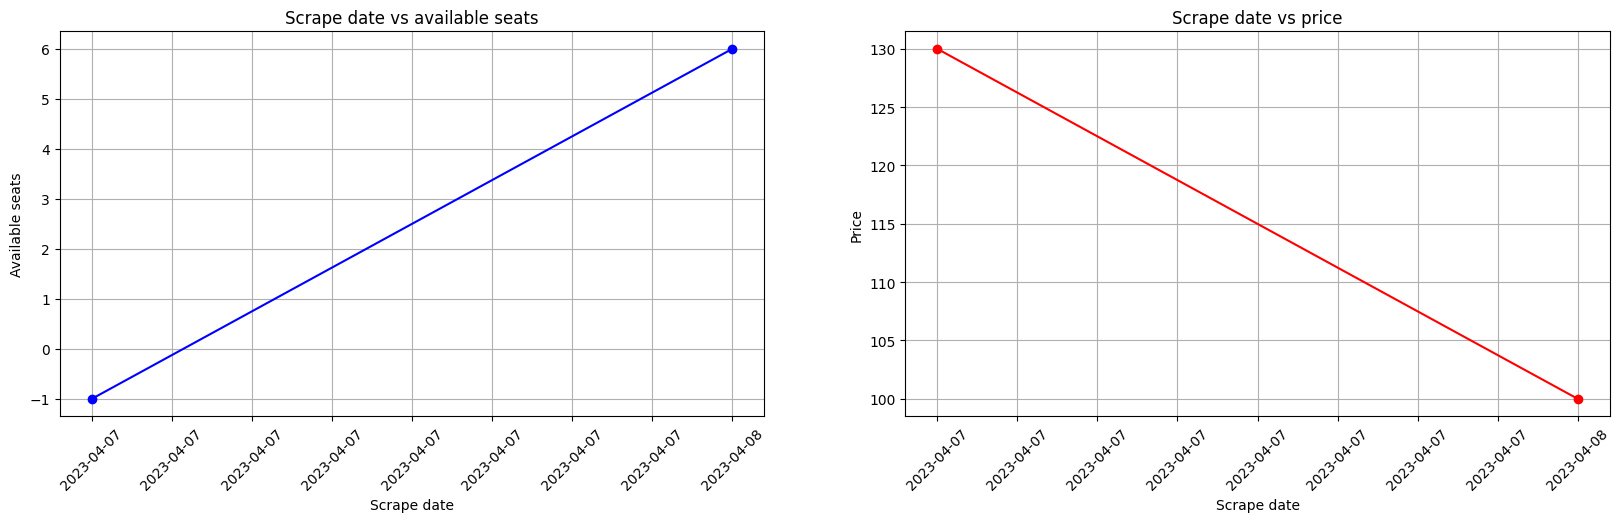

TB_ANR_ALC_2023-04-09_TB1101
Departure Date: 2023-04-09


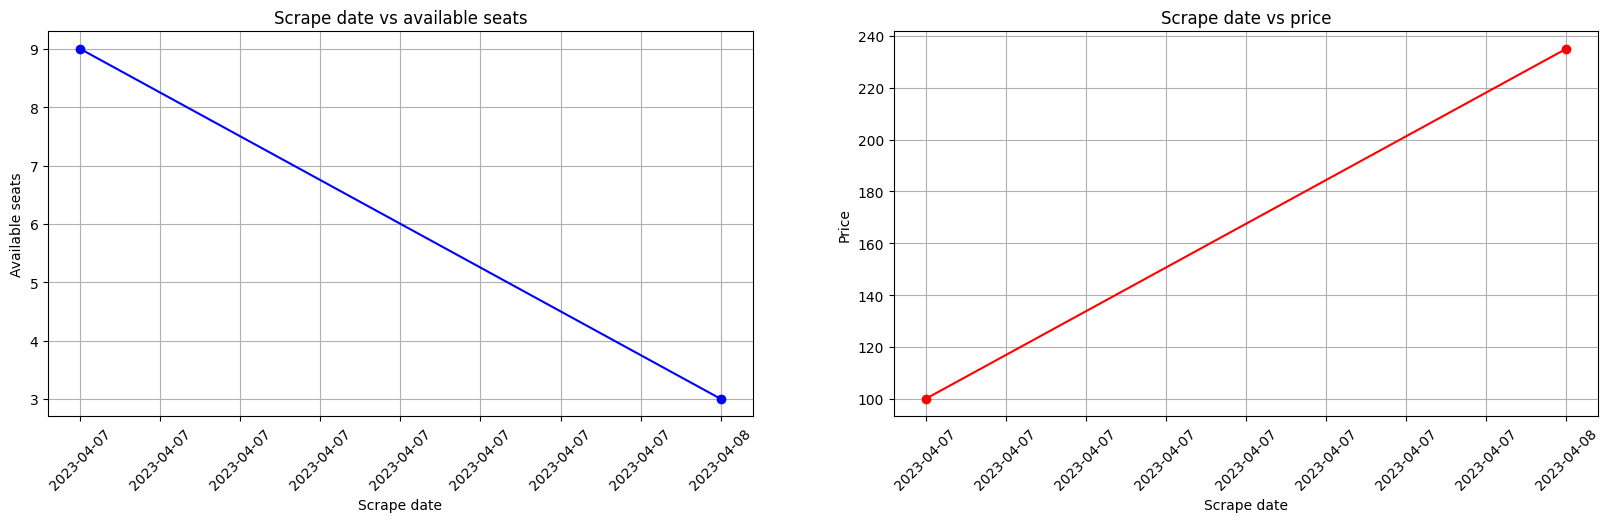

TB_ANR_ALC_2023-04-09_TB1103
Departure Date: 2023-04-09


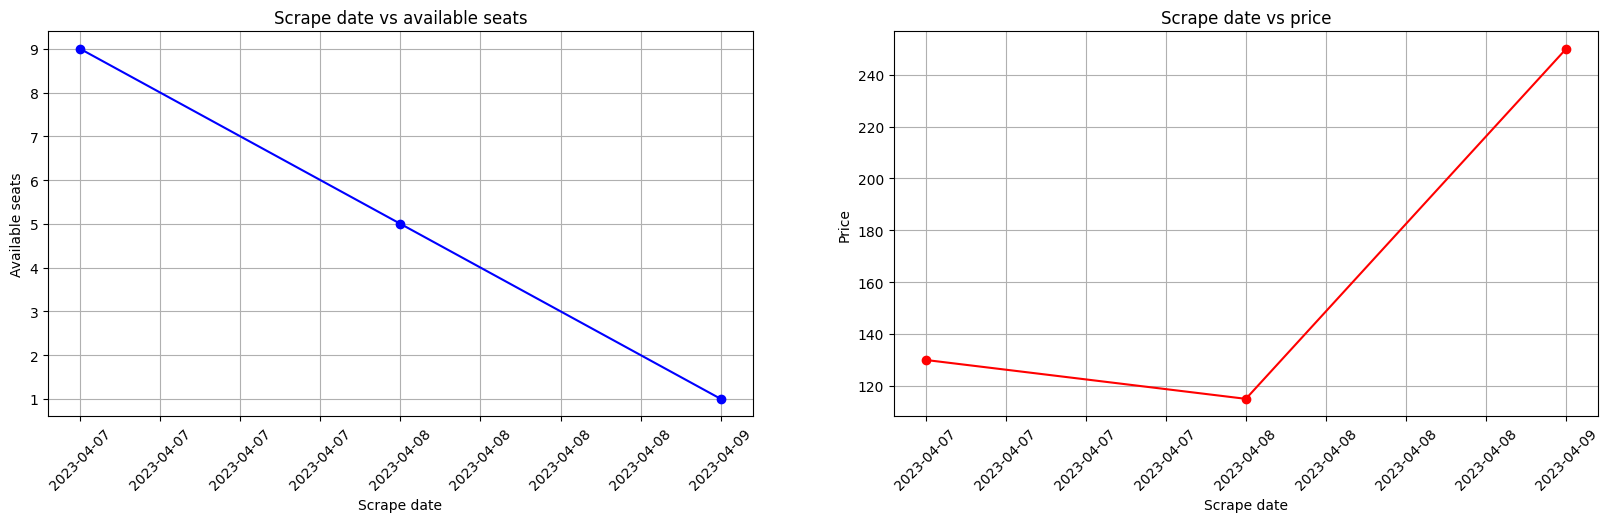

TB_ANR_ALC_2023-04-09_TB1105
Departure Date: 2023-04-09


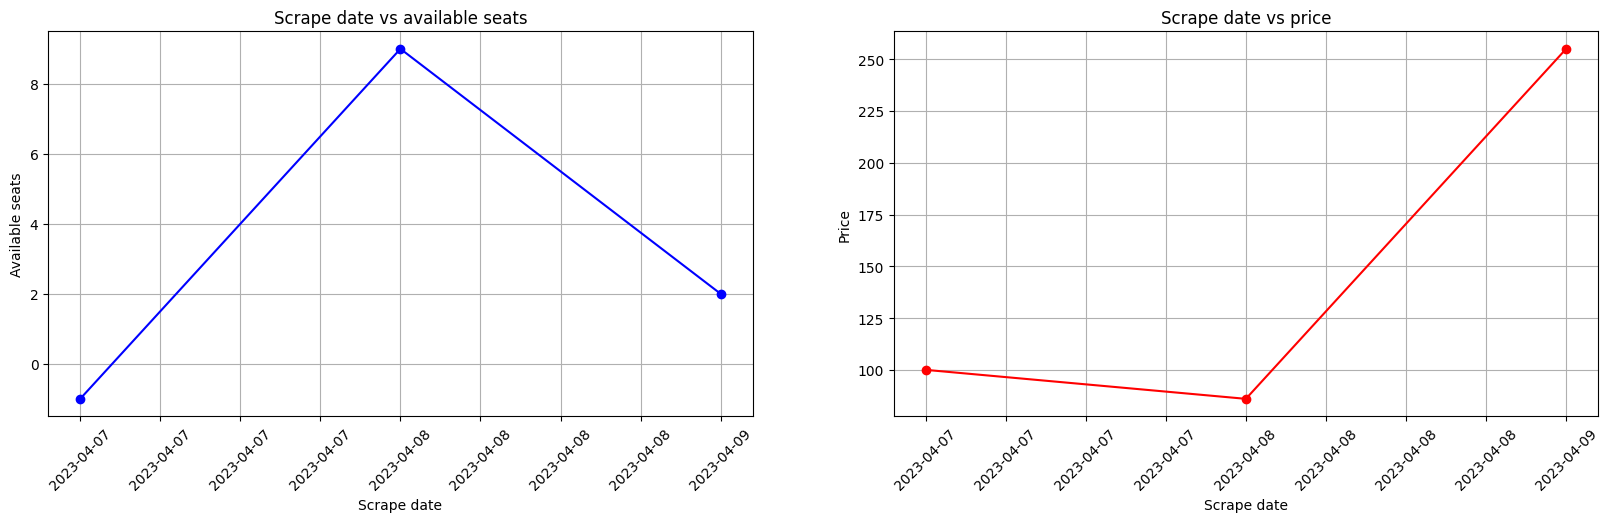

TB_BRU_ALC_2023-04-09_TB1113
Departure Date: 2023-04-09


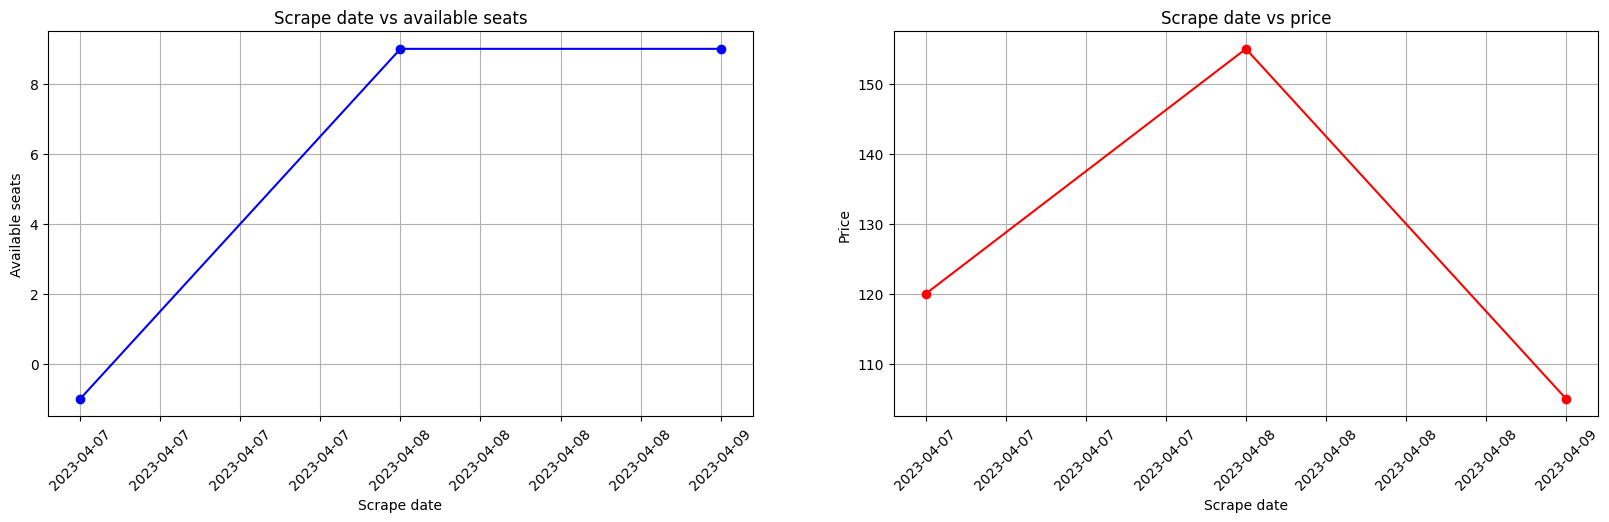

TB_LGG_ALC_2023-04-10_TB1161
Departure Date: 2023-04-10


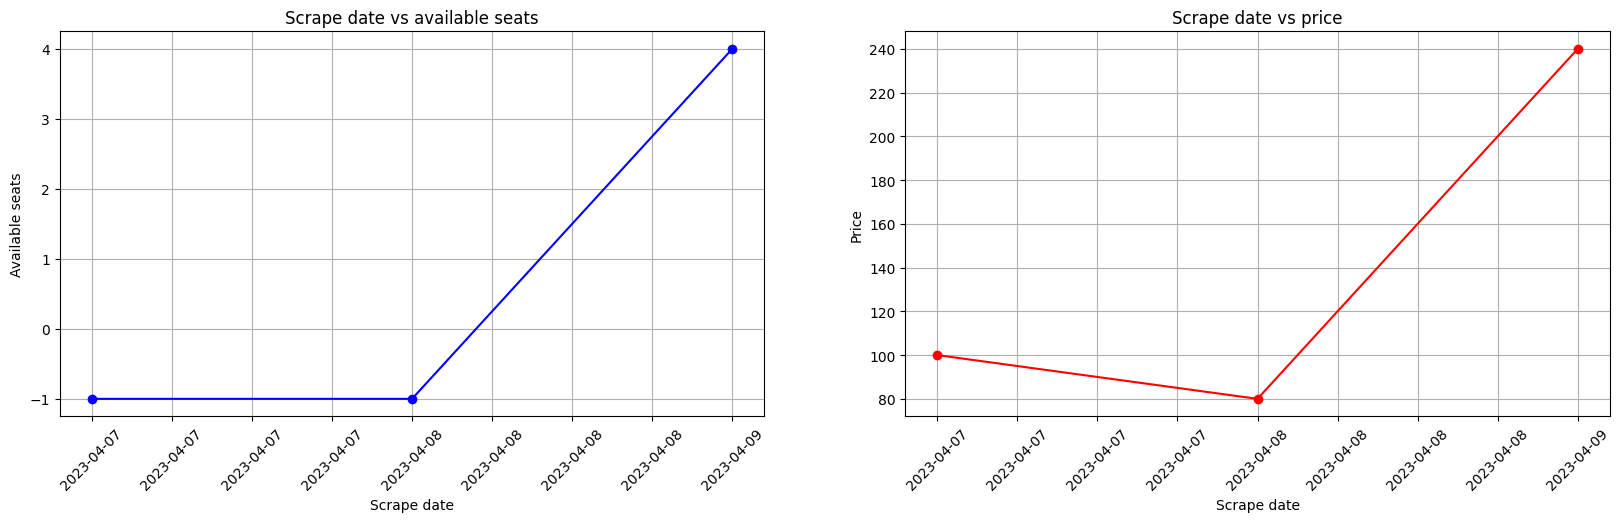

TB_ANR_ALC_2023-04-10_TB1101
Departure Date: 2023-04-10


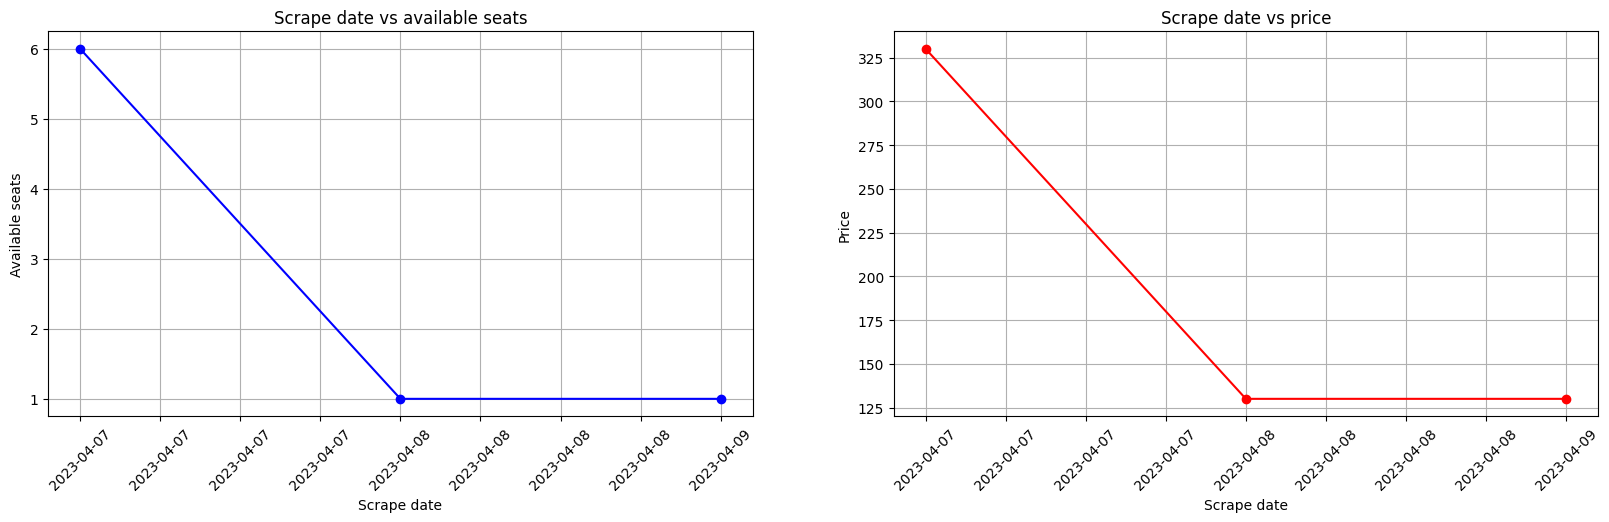

TB_OST_ALC_2023-04-10_TB1171
Departure Date: 2023-04-10


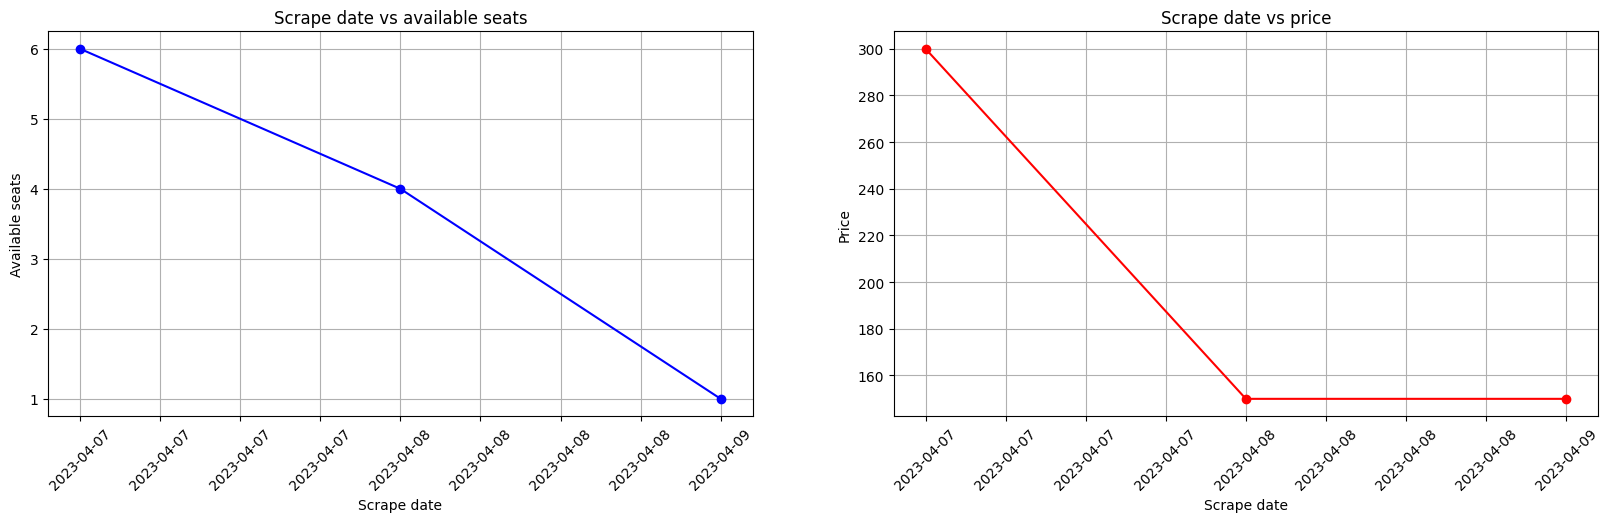

TB_OST_ALC_2023-04-11_TB1171
Departure Date: 2023-04-11


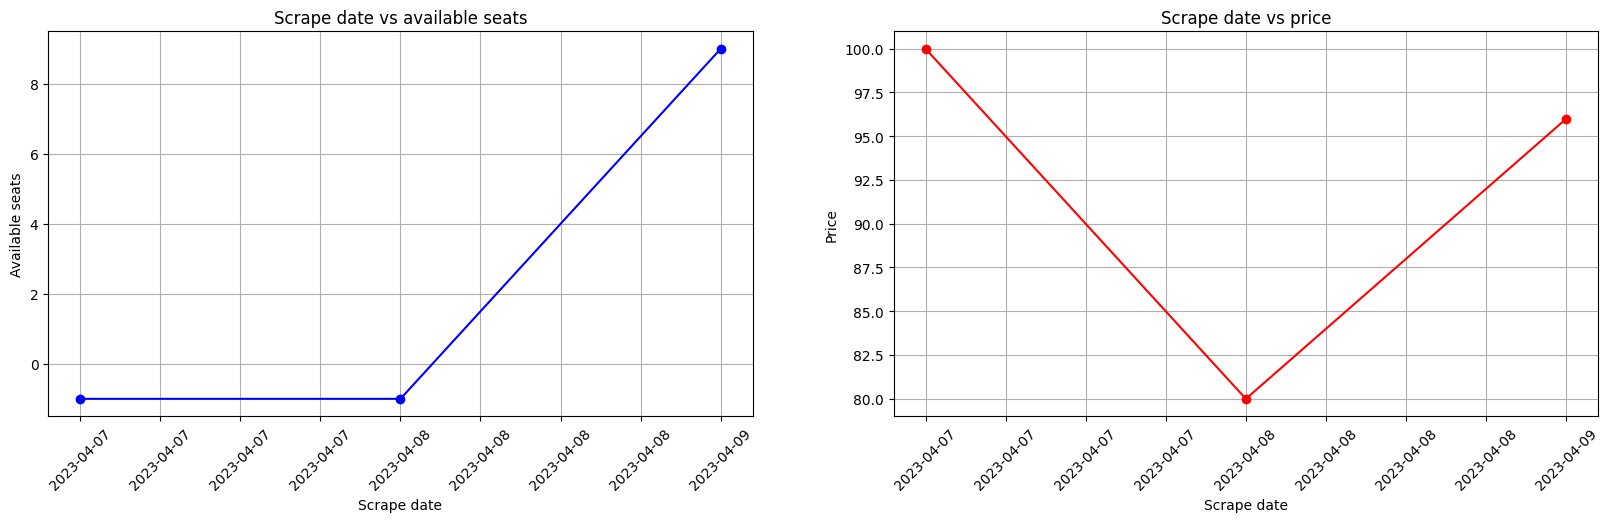

TB_BRU_ALC_2023-04-11_TB1135
Departure Date: 2023-04-11


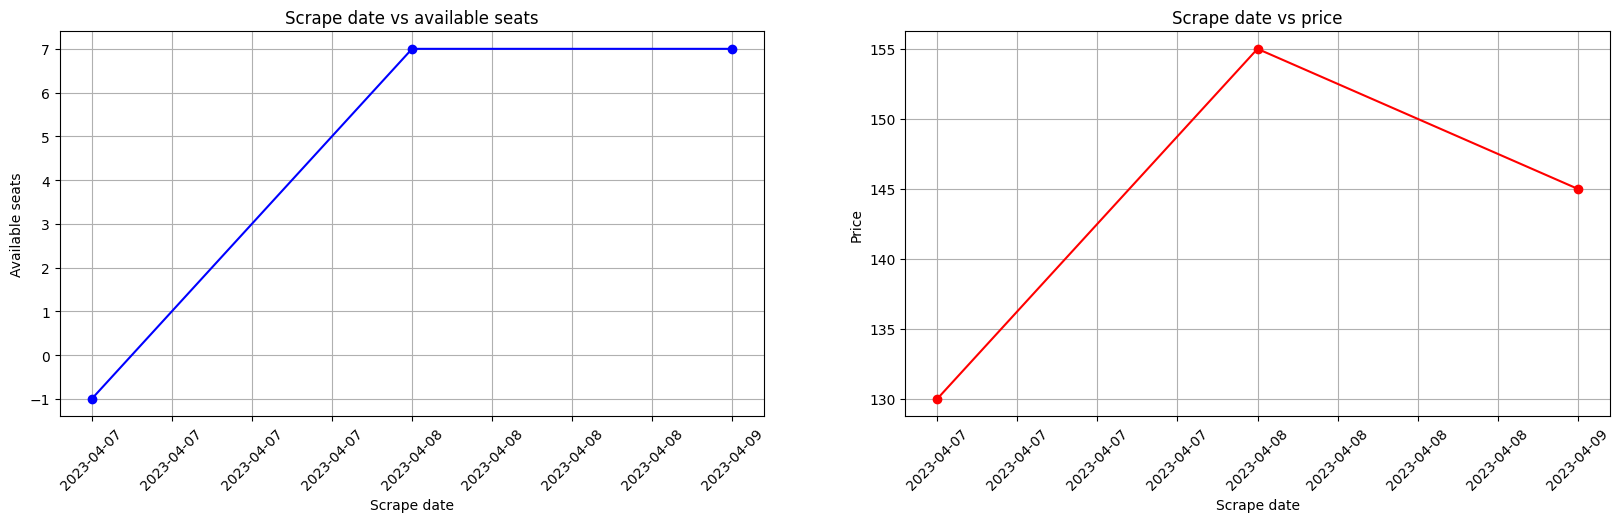

TB_LGG_AGP_2023-04-10_TB1161
Departure Date: 2023-04-10


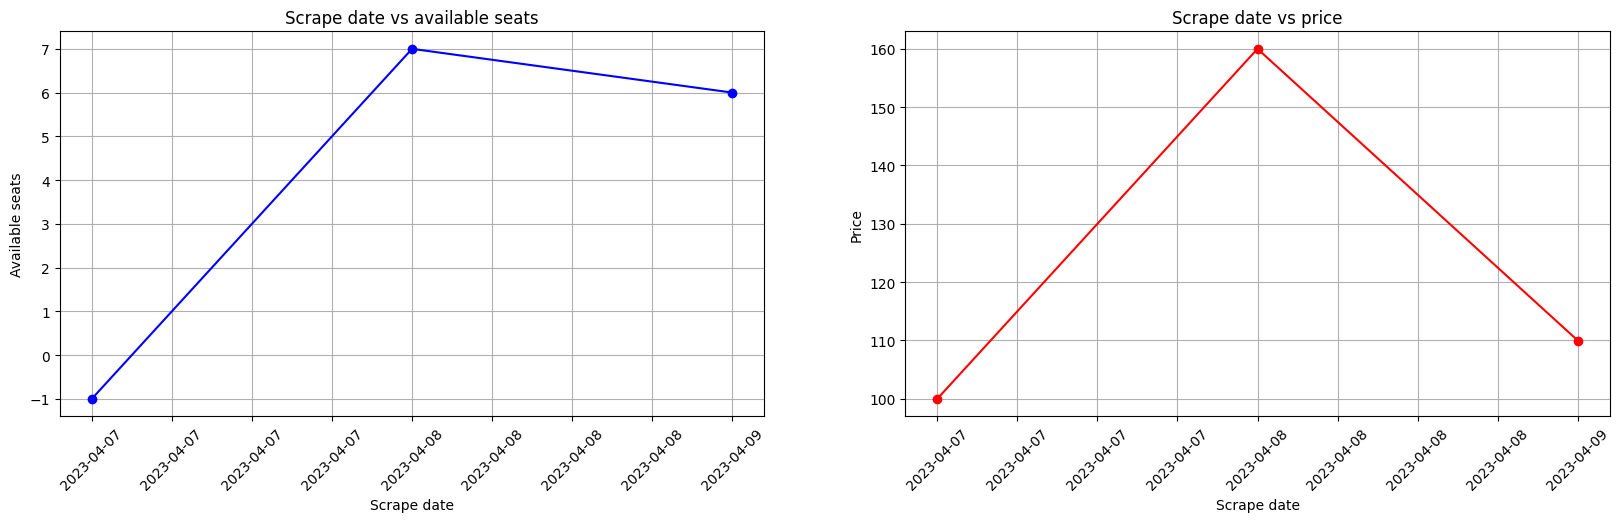

TB_OST_AGP_2023-04-10_TB1071
Departure Date: 2023-04-10


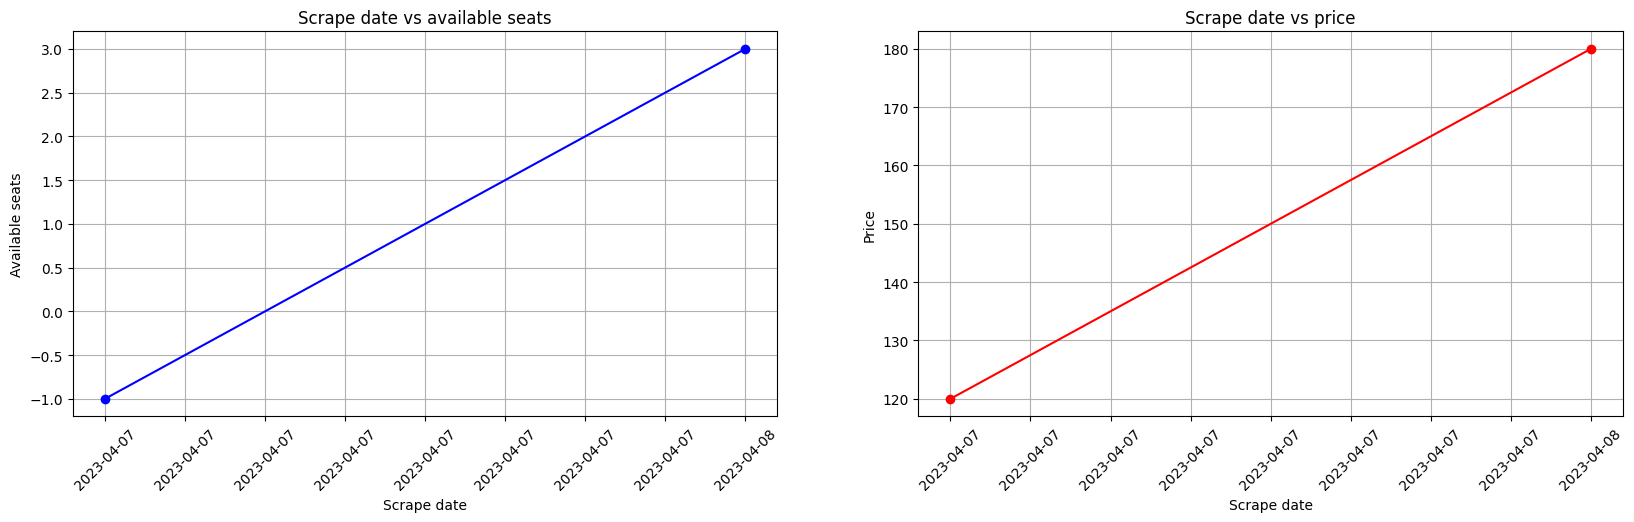

TB_BRU_AGP_2023-04-11_TB1011
Departure Date: 2023-04-11


KeyboardInterrupt: 

In [11]:
def get_flight_data(flight_key):
    flight_data = df_price[df_price['flightKey'] == flight_key]
    flight_data = flight_data.loc[:, ['scrapeDate', 'adultPrice', 'availableSeats']]
    dep_date = get_dep_date_from_key(flight_key)
    flight_data['departureDate'] = dep_date
    flight_data = flight_data.sort_values(by=['scrapeDate', 'departureDate'])
    return flight_data

def get_dep_date_from_key(flight_key):
    date_pattern = r'\d{4}-\d{2}-\d{2}'
    match = re.search(date_pattern, flight_key)
    if match:
        date = match.group()
        return date

unique_flight_keys = df_price['flightKey'].unique()

for i in unique_flight_keys:
    df = get_flight_data(i)
    df = df.sort_values(by=['departureDate', 'scrapeDate'])
    df = df.reset_index(drop=True)
    df = df.set_index('departureDate')
    df['scrapeDate'] = pd.to_datetime(df['scrapeDate'])

    if len(df) > 1 and (df['availableSeats'] != -1).any():

        print(i)

        for j in df.index.unique():

            print(f"Departure Date: {j}")

            fig, ax = plt.subplots(1, 2, figsize=(20, 5))

            ax[0].plot_date(df.loc[j]['scrapeDate'], df.loc[j]['availableSeats'], color='blue', linestyle='solid')
            ax[0].set_xlabel('Scrape date')
            ax[0].tick_params(axis='x', rotation=45)
            date_fmt = mdates.DateFormatter('%Y-%m-%d')
            ax[0].xaxis.set_major_formatter(date_fmt)
            ax[0].set_ylabel('Available seats')
            ax[0].set_title(f'Scrape date vs available seats')
            ax[0].grid()

            ax[1].plot_date(df.loc[j]['scrapeDate'], df.loc[j]['adultPrice'], color='red', linestyle='solid')
            ax[1].set_xlabel('Scrape date')
            ax[1].tick_params(axis='x', rotation=45)
            ax[1].xaxis.set_major_formatter(date_fmt)
            ax[1].set_ylabel('Price')
            ax[1].set_title(f'Scrape date vs price')
            ax[1].grid()

            plt.show()